In [1]:
import copy
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from collections import deque
from IPython.display import clear_output
from torch.nn import Sequential, Linear, ReLU, MSELoss
from torch.optim import Adam
from Gridworld import Gridworld

In [9]:
game = Gridworld(size = 4, mode = 'static')

game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [2]:
GPU = torch.device("cuda:0")
DIM_INPUT = 4*4*4
DIM_HIDDEN_1 = 150
DIM_HIDDEN_2 = 100
DIM_OUTPUT = 4
LR = 1e-3
GAMMA = 0.9
EPSILON = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [3]:
def get_state(game):
    return game.board.render_np().reshape(1, DIM_INPUT)

def noise(scale):
    return np.random.rand(1, DIM_INPUT) / scale

In [10]:
model = Sequential(
    Linear(DIM_INPUT, DIM_HIDDEN_1),
    ReLU(),
    Linear(DIM_HIDDEN_1, DIM_HIDDEN_2),
    ReLU(),
    Linear(DIM_HIDDEN_2, DIM_OUTPUT)
)

model = model.to(GPU)

loss_funct = MSELoss(reduction = 'mean')
optimizer = Adam(model.parameters(), lr = LR)

In [22]:
num_epochs = 1000
losses = []
len_games = []

for i_epoch in range(num_epochs):
    # For each epoch, start a new game
    game = Gridworld(size = 4, mode = 'static')
    actions_taken = 0
    # Get state as (1, 64) vector and add noise (0...0.1)
    state_ = get_state(game) + noise(10.0) 
    state = torch.from_numpy(state_)
    state = state.to(GPU, dtype = torch.float)
    # Is game still in progress or not
    game_in_progress = True
    # If in progress, play a game to completion
    while(game_in_progress == True):
        # Predict q-values for all the actions with Q-network
        q_val = model(state)
        q_val_np = q_val.cpu().data.numpy()
        # Select action using epsilon-greedy method
        if (random.random() < EPSILON):
            action = np.random.randint(0,4)
        else:
            action = np.argmax(q_val_np)       
        action_key = action_set[action]
        game.makeMove(action_key)
        actions_taken += 1
        # Get new state from game
        new_state_np = get_state(game) + noise(10.0)
        new_state = torch.from_numpy(new_state_np).to(GPU, dtype = torch.float)
        # Get reward
        reward = game.reward()
        # Find maximum q-value predicted from new state
        with torch.no_grad():
            q_target = model(new_state).cpu().data.numpy()
        q_max = np.max(q_target)
        # Calculate updated q-value using Q-learning algorithm
        if reward == -1:
            q_updated = (reward + (GAMMA * q_max))
        else:
            q_updated = reward
        # Update the q-value corresponding to the action that was chosen
        y = q_val_np
        y[0, action] = q_updated
        y = torch.from_numpy(y).to(GPU, dtype = torch.float)
        # Calucate loss
        loss = loss_funct(q_val, y)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        # Update model parameters
        optimizer.step()
        # Update state to new state
        state = new_state
        # Check if game was run to completion (Goal: 10 | Pit: -10 | Else: -1)
        if reward != -1:
            game_in_progress = False
    # Print progress
    if i_epoch % 100 == 0:
        print(f'Epoch: {i_epoch:03d} | Loss: {loss.item():.4f}')
    # Save length of game
    len_games.append(actions_taken)
    # Decrease epsilon after each epoch
    if EPSILON > 0.1:
        EPSILON = EPSILON - (1 / num_epochs)

Epoch: 000 | Loss: 7.1468
Epoch: 100 | Loss: 0.0149
Epoch: 200 | Loss: 0.0067
Epoch: 300 | Loss: 0.3283
Epoch: 400 | Loss: 0.0006
Epoch: 500 | Loss: 0.0021
Epoch: 600 | Loss: 0.0025
Epoch: 700 | Loss: 0.0718
Epoch: 800 | Loss: 0.0096
Epoch: 900 | Loss: 0.0089


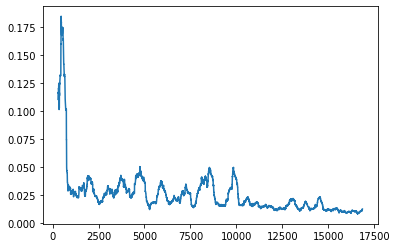

In [23]:
losses = pd.Series(losses)
losses = losses.rolling(300).mean()

plt.plot(losses);

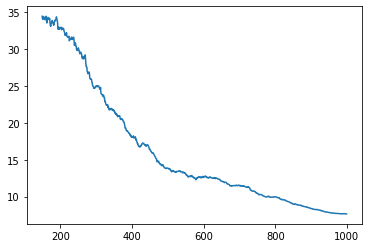

In [24]:
len_games = pd.Series(len_games)
len_games = len_games.rolling(150).mean()

plt.plot(len_games);

In [70]:
def test_model(model, mode = 'static'):
    actions_taken = 0
    test_game = Gridworld(mode = mode)
    state_np = get_state(test_game) + noise(10.0)
    state = torch.from_numpy(state_np).to(GPU, dtype = torch.float)
    
    print("Initial State:")
    print(test_game.display())
    
    game_in_progress = True
    while(game_in_progress == True):
        with torch.no_grad():
            q_val = model(state)
        qval_np = q_val.cpu().data.numpy()
        action_ = np.argmax(qval_np)
        action_key = action_set[action_]
        
        print(f'Move {actions_taken}, Taking action: {action_key}')
        
        test_game.makeMove(action_key)
        state_np = get_state(test_game) + noise(10.0)
        state = torch.from_numpy(state_np).to(GPU, dtype = torch.float)
        
        print(test_game.display())
        
        reward = test_game.reward()
        if reward != -1:
            game_in_progress = False
            print(f'Reward: {reward}')
        
        actions_taken += 1
        
        if (actions_taken > 15):
            print("Game lost; too many moves.")
            break

In [29]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move 0, Taking action: l
[['+' '-' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move 1, Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move 2, Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move 3, Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move 4, Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move 5, Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move 6, Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Reward: 10


## Experience replay

In [9]:
model = Sequential(
    Linear(DIM_INPUT, DIM_HIDDEN_1),
    ReLU(),
    Linear(DIM_HIDDEN_1, DIM_HIDDEN_2),
    ReLU(),
    Linear(DIM_HIDDEN_2, DIM_OUTPUT)
)

model = model.to(GPU)

loss_funct = MSELoss(reduction = 'mean')
optimizer = Adam(model.parameters(), lr = LR)

In [10]:
GAMMA = 0.9
EPSILON = 0.3
num_epochs = 5_000
max_actions = 50
batch_size = 200
replay_buffer_size = 1_000
replay_buffer = deque(maxlen = replay_buffer_size)
losses = []

for i_epoch in range(num_epochs):
    # Create game and get state with noise added
    game = Gridworld(size = 4, mode = 'random')
    state_np = get_state(game) + noise(100.0)
    state = torch.from_numpy(state_np).to(GPU, dtype = torch.float)
    actions_taken = 0
    game_in_progress = True
    # ------------------ Game begins ------------------
    while(game_in_progress == True):
        q_val = model(state)
        q_val_np = q_val.cpu().data.numpy()
        # Select action according to epsilon-greedy method
        if (random.random() < EPSILON):
            action = np.random.randint(0, 4)
        else:
            action = np.argmax(q_val_np)
        action_key = action_set[action]
        game.makeMove(action_key)
        actions_taken += 1
        # Get new state
        new_state_np = get_state(game) + noise(100.0)
        new_state = torch.from_numpy(new_state_np).to(GPU, dtype = torch.float)
        # Get reward
        reward = game.reward()
        # if the game is over after taking action, the target just becomes the reward
        if reward == 10 or reward == -10:
            done = True
        else:
            done = False
        # Add (s, a, r, s', d) tuple to experiences
        experience = (state, action, reward, new_state, done)
        replay_buffer.append(experience)
        # Update state
        state = new_state
        # If buffer full, start minibatch training
        if len(replay_buffer) > batch_size:           
            # Take a random minibatch from replay buffer to train model on
            batch = random.sample(replay_buffer, batch_size)
            # Separate the tuple
            state_b = torch.cat([s for (s, a, r, s_n, d) in batch]).to(GPU, dtype = torch.float)
            action_b = torch.Tensor([a for (s, a, r, s_n, d) in batch]).to(GPU, dtype = torch.float)
            reward_b = torch.Tensor([r for (s, a, r, s_n, d) in batch]).to(GPU, dtype = torch.float)
            new_state_b = torch.cat([s_n for (s, a, r, s_n, d) in batch]).to(GPU, dtype = torch.float)
            done_b = torch.Tensor([d for (s, a, r, s_n, d) in batch]).to(GPU, dtype = torch.float)
            # Re-compute q-values for states minibatch to get gradient
            q_b = model(state_b)
            # Compute next state but no gradient
            with torch.no_grad():
                q_new_b = model(new_state_b)
            # Calculate updated q-value using Q-learning algorithm
            q_targets_b = reward_b + GAMMA * ((1 - done_b) * torch.max(q_new_b, dim = 1)[0])
            # Update the q-value corresponding to the action that was chosen 
            q_preds_b = q_b.gather(dim = 1, index = action_b.long().unsqueeze(dim = 1)).squeeze()
            # Calculate minibatch loss
            loss_b = loss_funct(q_preds_b, q_targets_b.detach())
            optimizer.zero_grad()
            loss_b.backward()
            losses.append(loss_b.item())
            # Update model parameters
            optimizer.step()
        # Check if game was run to completion or max_actions was exceeded
        if reward != -1 or actions_taken > max_actions:
            game_in_progress = False
            actions_taken = 0 
    # ------------------ Game ends ------------------
    # Print progress
    if i_epoch % 500 == 0:
        print(f'Epoch: {i_epoch:04d} | Loss: {loss_b.item():.5f}')

Epoch: 0000 | Loss: 0.14900
Epoch: 0500 | Loss: 0.16060
Epoch: 1000 | Loss: 0.07001
Epoch: 1500 | Loss: 0.19239
Epoch: 2000 | Loss: 0.15441
Epoch: 2500 | Loss: 0.06417
Epoch: 3000 | Loss: 0.08093
Epoch: 3500 | Loss: 0.09108
Epoch: 4000 | Loss: 0.16263
Epoch: 4500 | Loss: 0.07381


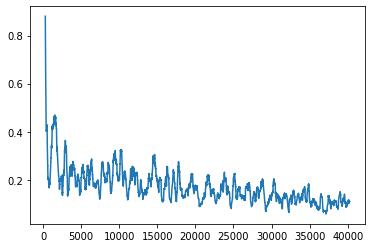

In [11]:
losses = pd.Series(losses)
losses = losses.rolling(300).mean()

plt.plot(losses);

In [12]:
def test_model(model, mode = 'random'):
    result = True
    actions_taken = 0
    test_game = Gridworld(mode = mode)
    state_np = get_state(test_game) + noise(100.0)
    state = torch.from_numpy(state_np).to(GPU, dtype = torch.float)
    game_in_progress = True
    while(game_in_progress == True):
        with torch.no_grad():
            q_val = model(state)
        qval_np = q_val.cpu().data.numpy()
        action = np.argmax(qval_np)
        action_key = action_set[action]      
        test_game.makeMove(action_key)
        actions_taken += 1
        if (actions_taken > 15):
            result = False
            break
        state_np = get_state(test_game) + noise(100.0)
        state = torch.from_numpy(state_np).to(GPU, dtype = torch.float)        
        reward = test_game.reward()
        if reward == -10:
            game_in_progress = False
            result = False
        elif reward == 10:
            game_in_progress = False
            result = True
        elif reward == -1:
            game_in_progress = True
    return result

In [13]:
wins = []

for i in range(1000):
    res = test_model(model)
    wins.append(res)
    
print(f'Win percentage: {np.mean(wins)}')

Win percentage: 0.827


## Target network

In [16]:
model = Sequential(
    Linear(DIM_INPUT, DIM_HIDDEN_1),
    ReLU(),
    Linear(DIM_HIDDEN_1, DIM_HIDDEN_2),
    ReLU(),
    Linear(DIM_HIDDEN_2, DIM_OUTPUT)
)

model = model.to(GPU)

model_target = copy.deepcopy(model)
model_target.load_state_dict(model.state_dict())
model_target.to(GPU)

loss_funct = MSELoss(reduction = 'mean')
#loss_funct_target = MSELoss(reduction = 'mean')

optimizer = Adam(model.parameters(), lr = LR)
#optimizer_target = Adam(model_target.parameters(), lr = LR)

In [17]:
num_epochs = 5_000
max_actions = 50
batch_size = 200
replay_buffer_size = 1_000
replay_buffer = deque(maxlen = replay_buffer_size)
sync_freq = 50
losses = []
game_times = []

for i_epoch in range(num_epochs):
    game = Gridworld(size = 4, mode = 'random')
    state_np = get_state(game) + noise(100.0)
    state = torch.from_numpy(state_np).to(GPU, dtype = torch.float)
    actions_taken = 0
    time_start = time.time()
    game_in_progress = True
    # ------------------ Game begins ------------------
    while(game_in_progress == True):
        # Copy model parameters to target network
        if i_epoch % sync_freq == 0:           
            model_target.load_state_dict(model.state_dict())    
        q_val = model(state)
        q_val_np = q_val.cpu().data.numpy()
        if (random.random() < EPSILON):
            action = np.random.randint(0, 4)
        else:
            action = np.argmax(q_val_np)
        action_key = action_set[action]
        game.makeMove(action_key)
        actions_taken += 1
        new_state_np = get_state(game) + noise(100.0)
        new_state = torch.from_numpy(new_state_np).to(GPU, dtype = torch.float)
        reward = game.reward()
        if reward == 10 or reward == -10:
            done = True
        else:
            done = False
        experience = (state, action, reward, new_state, done)
        replay_buffer.append(experience)
        state = new_state
        # ------------------ Experience replay begins ------------------
        if len(replay_buffer) > batch_size:           
            # Take a random minibatch from replay buffer to train model on
            batch = random.sample(replay_buffer, batch_size)
            # Separate the tuple
            state_b = torch.cat([s for (s, a, r, s_n, d) in batch]).to(GPU, dtype = torch.float)
            action_b = torch.Tensor([a for (s, a, r, s_n, d) in batch]).to(GPU, dtype = torch.float)
            reward_b = torch.Tensor([r for (s, a, r, s_n, d) in batch]).to(GPU, dtype = torch.float)
            new_state_b = torch.cat([s_n for (s, a, r, s_n, d) in batch]).to(GPU, dtype = torch.float)
            done_b = torch.Tensor([d for (s, a, r, s_n, d) in batch]).to(GPU, dtype = torch.float)
            # Re-compute q-values for states minibatch to get gradient
            q_b = model(state_b)
            # Compute next state with target network
            with torch.no_grad():
                q_new_b = model_target(new_state_b)
            # Calculate updated q-value using Q-learning algorithm
            q_targets_b = reward_b + GAMMA * ((1 - done_b) * torch.max(q_new_b, dim = 1)[0])
            # Update the q-value corresponding to the action that was chosen 
            q_preds_b = q_b.gather(dim = 1, index = action_b.long().unsqueeze(dim = 1)).squeeze()
            # Calculate minibatch loss
            loss_b = loss_funct(q_preds_b, q_targets_b.detach())
            optimizer.zero_grad()
            loss_b.backward()
            losses.append(loss_b.item())
            # Update model parameters
            optimizer.step()
        # ------------------ Experience replay ends ------------------
        # Check if game was run to completion or max_actions was exceeded
        if reward != -1 or actions_taken > max_actions:
            game_in_progress = False
            actions_taken = 0 
    # ------------------ Game ends ------------------
    time_end = time.time()
    game_times.append(time_end - time_start)
    game_time_left = (num_epochs - i_epoch) * np.mean(game_times)
    if i_epoch % 500 == 0:
        print(f'Epoch: {i_epoch:04d} | Loss: {loss_b.item():.5f} | Approx. time left: {(game_time_left / 60):.3f} min')

Epoch: 0000 | Loss: 0.08044 | Approx. time left: 0.096 min
Epoch: 0500 | Loss: 0.40114 | Approx. time left: 3.268 min
Epoch: 1000 | Loss: 1.15468 | Approx. time left: 2.529 min
Epoch: 1500 | Loss: 0.93117 | Approx. time left: 1.870 min
Epoch: 2000 | Loss: 0.57463 | Approx. time left: 1.432 min
Epoch: 2500 | Loss: 0.46445 | Approx. time left: 1.077 min
Epoch: 3000 | Loss: 0.84980 | Approx. time left: 0.795 min
Epoch: 3500 | Loss: 0.54817 | Approx. time left: 0.561 min
Epoch: 4000 | Loss: 0.40526 | Approx. time left: 0.354 min
Epoch: 4500 | Loss: 0.36527 | Approx. time left: 0.168 min


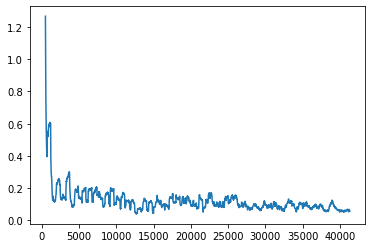

In [18]:
losses = pd.Series(losses)
losses = losses.rolling(500).mean()

plt.plot(losses);

In [19]:
wins = []

for i in range(2000):
    res = test_model(model)
    wins.append(res)
    
print(f'Win percentage: {np.mean(wins)}')

Win percentage: 0.8825
